CNN para Detecção/Diagnóstico de Falhas

Disciplina: Redes Neurais Artificiais

Professor: Thomas Rauber

Grupo:
- Alan Carlos Pereira Pinto
- Alexander de Oliveira da Silva
- Iran Freitas Ribeiro

--------------------------------------------------------



**Sumarização dos modelos**

Construímos 21 classificadores CNNs com 2 estruturas básicas: uma para falhas mais complexas de serem classificadas, onde o *overfitting* pode ocorrer logo no início do treinamento e para falhas "mais simples", onde o *overfitting* pode ser controlado basicamente treinando o modelo por menos épocas. 

Modelo com menos camadas:

``CNN -> MaxPooling2D -> CNN -> MaxPooling2D -> Dropout -> Dense -> Dense``

Modelo com mais camadas:

``CNN -> MaxPooling2D -> Dropout -> CNN -> MaxPooling2D -> Dropout -> Dense -> Dropout -> Dense``

Durante o treinamento, são utilizados diferentes parâmetros para evitar um possível *overfitting* (mesmo nos casos onde a falha é mais "comportada") como: quantidade de neurônios, em quais camadas o *dropout* vai ser aplicado e a técnica de [Eearly Stopping](https://keras.io/api/callbacks/early_stopping/).

## Modelos

Os modelos treinados são salvos na pasta "modelos" e a acurácia de cada modelo pode ser vista no final do Notebook.

In [21]:
import pandas as pd
import numpy as np
import glob
import tensorflow as tf
from tensorflow.keras import models, layers, losses, regularizers, callbacks, constraints, optimizers
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import os

In [3]:
def normalize(d):
  media_treino = d.mean(axis=0)
  std_treino = d.std(axis=0, ddof=0)
  d = d - media_treino
  d = d/std_treino
  return d

def get_entradas_labels_treino(dados_normais, falha_treino, colunas):
  """
  Retorna os dados de treino (Entrada e labels)
  """

  # lê o arquivo de falha   
  dfalha_i = pd.read_csv(falha_treino, delim_whitespace=True, header=None)
  dfalha_i['falha'] = np.ones(len(dfalha_i), dtype='int')*1 # 1
  # concatena os dados normais com os dados de falha
  dtreino = pd.concat([dados_normais, dfalha_i]) 
  X = dtreino[colunas].values
  labels_treino = dtreino['falha'].values
  # shape (X, 13, 2, 2) de acordo o padrão esperado por uma cnn
  X = X.reshape(len(X), 13, 2, 2)
  labels_treino = labels_treino.reshape(len(labels_treino), 1)
  # normaliza os dados de treino
  X = normalize(X)
  
  return X, labels_treino

def get_entradas_labels_teste(falha_teste, colunas):
  """
  Retorna os dados de teste (entrada e labels)
  
  """
  ### dados de teste
  dte = pd.read_csv(falha_teste, delim_whitespace=True, header=None)
  dte['falha'] = np.ones(len(dte), dtype='int')*1
  # primeiros 160 são dados de normalidade
  dte.loc[np.arange(160), 'falha'] = 0

  X_teste = dte[colunas].values
  labels_teste = dte['falha'].values
  # apenas para manter o padrão entre 0 e 1
  labels_teste = labels_teste/np.max(labels_teste)
  X_teste = normalize(X_teste)
  X_teste = X_teste.reshape(len(X_teste), 13, 2, 2)
  return X_teste, labels_teste

def plot_falha(falha_treino):
  dfalha_i = pd.read_csv(falha_treino, delim_whitespace=True, header=None)
  dfalha_i['falha'] = np.ones(len(dfalha_i), dtype='int')*1 # 1
  dfalha_i[[0,1,2]].plot()

In [3]:
# todos os arquivos
arquivos = glob.glob('data/*.dat')
# arquivos de teste
arquivos_teste = sorted(glob.glob('data/*te.dat'))
# arquivos de treino (falha)
arquivos_treino = sorted(list(set(arquivos).difference(arquivos_teste)))

In [24]:
def define_model(dropouts=[], lnormalize=False, r=1, thirdl=False, n_steps=10, nouts=2):
    """
    Retorna um modelo CNN

    Params:
        - dropout: lista de camadas onde o dropout será aplicado
        - lnormalize: indica se normalização l2 será aplicado à camada
        - r: número utilizado para reduzir o número de neurônios em cada camada
        - thirdl: indica se o modelo possui uma camada CNN adicional no final. O modelo mais simples possui apenas 2 camadas
    """

    m  = models.Sequential()
    if lnormalize:
        m.add(layers.Conv2D(int(64/r), (2, 2), activation='relu', input_shape=(13, 2, 2), name='conv1', kernel_regularizer=regularizers.l2(0.01)))
    else:
        m.add(layers.Conv2D(int(64/r), (2, 2), activation='relu', input_shape=(13, 2, 2), name='conv1'))
    m.add(layers.MaxPooling2D((2, 1), name='maxpooling1'))
    if dropouts[0]:
        m.add(layers.Dropout(0.4))
    if lnormalize:
        m.add(layers.Conv2D(int(64/r), (2, 1), activation='relu', name='conv2', 
            kernel_regularizer=regularizers.l2(0.01)))
    else:
        m.add(layers.Conv2D(int(64/r), (2, 1), activation='relu', name='conv2'))    
    if thirdl:        
        m.add(layers.MaxPooling2D((2, 1), name='maxpooling2'))
        if dropouts[1]:
            m.add(layers.Dropout(0.4))
        if lnormalize:
            m.add(layers.Conv2D(int(64/r), (2, 1), activation='relu', name='conv3', 
                kernel_regularizer=regularizers.l2(0.01)))
        else:
            m.add(layers.Conv2D(int(64/r), (2, 1), activation='relu', name='conv3'))
    m.add(layers.Flatten())
    m.add(layers.Dense(int(32/r), activation='relu'))
    if thirdl:
        if dropouts[2]:
            m.add(layers.Dropout(0.2))
    # 2 classes: normal (0) e falha (XX)
    m.add(layers.Dense(nouts, name="previsoes"))
    
    opt = optimizers.Adam(learning_rate=1e-4)
    #opt = optimizers.SGD()
    m.compile(optimizer=opt, loss=losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    return m

def plot_acc_loss(title, hist):
    """
    Plota a accurácia (treino e validação) e perda (treino e validação) do modelo ao longo das épocas    
    """
    fig, ax = plt.subplots(ncols=2, figsize=(8,3))
    ax[0].plot (hist.history['accuracy'], label='acc')
    ax[0].plot (hist.history['val_accuracy'], label='val_acc')
    ax[0].legend()
    ax[1].plot (hist.history['loss'], label='loss')
    ax[1].plot (hist.history['val_loss'], label='val_loss')
    ax[1].legend()
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

In [5]:
dnormal = pd.read_csv("data/d00.dat", delim_whitespace=True, header=None)
dnormal['falha'] = np.zeros(len(dnormal), dtype='int')
colunas = np.arange(52)

In [28]:
falha = 21
X_treino, labels_treino = get_entradas_labels_treino(dnormal, arquivos_treino[falha], colunas)
X_teste, labels_teste = get_entradas_labels_teste(arquivos_teste[falha], colunas)

In [8]:
# diferntes configurações para aplicação do dropout
lista_drops = [
    [0, 0, 1], [0, 1, 1], [1, 1, 1], [1, 1, 0], [1, 0, 0], [1, 0, 1], [0, 1, 0]
]
# configurações para aplicação do dropout no modelo mais simples
lista_drops2 = [
    [0, 0], [0, 1], [1, 0], [1, 1]
]

**Escolha do melhor modelo para a i-ésima falha**

- Modelo com maior acurácia nos dados de teste (``val_acc``) e em que acurácia nos dados de teste apresente uma tendência de crescimento.

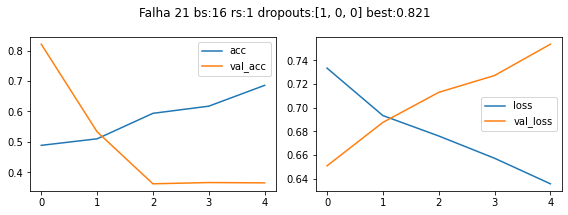

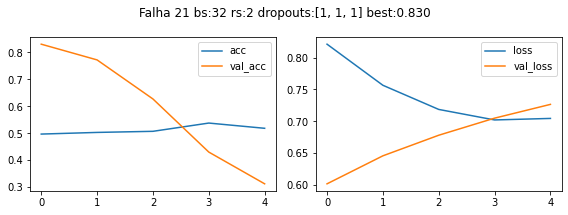

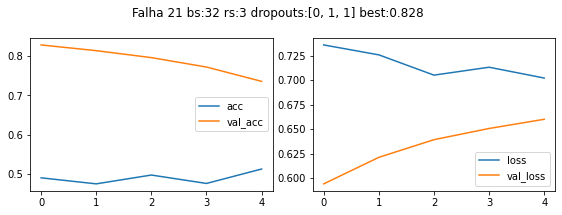

In [31]:
# lista de batch sizes
batch_sizes = [16, 32, 64]
# lista 
rs = [1, 2, 3]
treshold = 0.81
for b in batch_sizes:    
    for r in rs:
        for ld in lista_drops:
            loss_monitor = callbacks.EarlyStopping(monitor='val_accuracy', patience=4, mode='max')
            n_steps = X_treino.shape[0]//b
            cnn = define_model(dropouts=ld, lnormalize=False, r=r, thirdl=True, n_steps=n_steps)
            hist = cnn.fit(X_treino, labels_treino, batch_size=b, verbose=0, epochs=200, callbacks=[loss_monitor], validation_data=(X_teste, labels_teste))
            title = "Falha {} bs:{} rs:{} dropouts:{} best:{:.3f}".format(falha, b, r, ld, loss_monitor.best)
            if loss_monitor.best>treshold:
                plot_acc_loss(title, hist)          

**Salvando melhor modelo para a i-ésima falha**

- Os parâmetros do melhor modelo são utilizados para definir uma nova CNN
- Dada a natureza aleatória dos algoritmos de redes neurais, a CNN é treinada e salva algumas vezes
- O modelo com maior acurácia é mantido e os outros excluídos

In [81]:
falha = 21
X_treino, labels_treino = get_entradas_labels_treino(dnormal, arquivos_treino[falha], colunas)
X_teste, labels_teste = get_entradas_labels_teste(arquivos_teste[falha], colunas)

In [83]:
bs = 16
r = 3
n_steps = X_treino.shape[0]//bs
for i in range(10):
    monitor = [callbacks.EarlyStopping(monitor='val_accuracy', patience=4, 
                        mode='max', restore_best_weights=True),
            callbacks.ModelCheckpoint("modelos/f{}.h5".format(falha),monitor='val_accuracy', save_weights_only=False, 
                        mode='max', save_best_only=True)
            ]
    cnn = define_model(dropouts=[0, 1], lnormalize=True, r=r, thirdl=False, n_steps=n_steps)
    hist = cnn.fit(X_treino, labels_treino, verbose=0, batch_size=bs, epochs=200,
                validation_data=(X_teste, labels_teste), callbacks=[monitor])
    best = monitor[0].best
    os.rename("modelos/f{}.h5".format(falha), "modelos/f{}_{:.3f}.h5".format(falha, best))   

**Plotagem da acurácia dos 21 classificadores**

In [84]:
accs_modelos = []
for falha in range(1,22):
    # carrega o modelo salvo
    trained_cnn = tf.keras.models.load_model('modelos/f{}.h5'.format(falha))
    X_teste, labels_teste = get_entradas_labels_teste(arquivos_teste[falha], colunas)
    labels_pred = np.argmax(trained_cnn.predict(X_teste, verbose=0), axis=1)
    acc = accuracy_score(labels_pred, labels_teste)
    accs_modelos.append(acc)

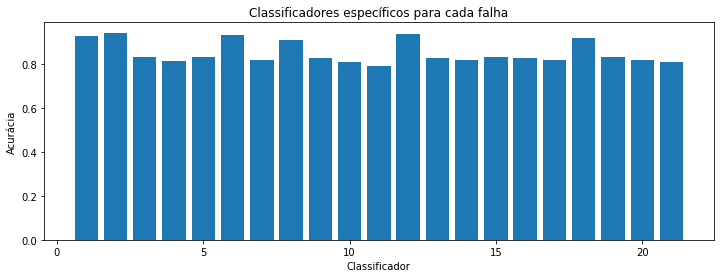

In [88]:
fig, ax = plt.subplots(figsize=(12,4))
ax.bar(range(1,22), accs_modelos)
ax.set_xlabel("Classificador")
ax.set_ylabel("Acurácia")
ax.set_title("Classificadores específicos para cada falha");

**Escolha de um modelo entre os 21 salvos**

- A acurácia de cada modelo é verificada para cada falha
- O modelo com maior acurácia média é escolhido

In [89]:
dict_modelo = {}
for modelo in range(1,22):
    accs_modelos = []
    trained_cnn = tf.keras.models.load_model('modelos/f{}.h5'.format(modelo))
    for falha in range(1,22):
        X_teste, labels_teste = get_entradas_labels_teste(arquivos_teste[falha], colunas)
        labels_pred = np.argmax(trained_cnn.predict(X_teste, verbose=0), axis=1)
        acc = accuracy_score(labels_pred, labels_teste)
        accs_modelos.append(acc)
    dict_modelo[modelo] = accs_modelos

In [91]:
df_acuracias = pd.DataFrame(dict_modelo)
df_acuracias

,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
0,0.926042,0.563542,0.831250,0.813542,0.834375,0.546875,0.827083,0.713542,0.830208,0.765625,...,0.751042,0.814583,0.820833,0.833333,0.829167,0.826042,0.631250,0.833333,0.803125,0.815625
1,0.704167,0.942708,0.832292,0.829167,0.830208,0.565625,0.808333,0.622917,0.821875,0.770833,...,0.816667,0.788542,0.820833,0.835417,0.825000,0.831250,0.658333,0.833333,0.762500,0.822917
2,0.816667,0.672917,0.832292,0.814583,0.833333,0.665625,0.826042,0.815625,0.828125,0.804167,...,0.839583,0.819792,0.821875,0.832292,0.831250,0.823958,0.738542,0.833333,0.810417,0.833333
3,0.803125,0.702083,0.832292,0.815625,0.832292,0.631250,0.818750,0.798958,0.819792,0.798958,...,0.832292,0.827083,0.831250,0.833333,0.822917,0.826042,0.682292,0.833333,0.821875,0.829167
4,0.798958,0.668750,0.830208,0.821875,0.833333,0.615625,0.816667,0.722917,0.818750,0.781250,...,0.810417,0.819792,0.825000,0.830208,0.830208,0.832292,0.683333,0.833333,0.811458,0.819792
5,0.829167,0.218750,0.821875,0.828125,0.833333,0.932292,0.834375,0.611458,0.822917,0.838542,...,0.807292,0.829167,0.833333,0.833333,0.825000,0.825000,0.827083,0.833333,0.810417,0.832292
6,0.767708,0.603125,0.831250,0.821875,0.833333,0.582292,0.819792,0.676042,0.830208,0.772917,...,0.711458,0.803125,0.821875,0.833333,0.825000,0.825000,0.683333,0.833333,0.813542,0.825000
7,0.870833,0.604167,0.832292,0.815625,0.833333,0.596875,0.814583,0.908333,0.827083,0.766667,...,0.890625,0.837500,0.820833,0.832292,0.832292,0.833333,0.786458,0.833333,0.836458,0.811458
8,0.822917,0.625000,0.831250,0.804167,0.832292,0.654167,0.821875,0.801042,0.828125,0.808333,...,0.828125,0.809375,0.832292,0.832292,0.826042,0.817708,0.718750,0.833333,0.807292,0.819792
9,0.827083,0.688542,0.828125,0.817708,0.833333,0.625000,0.822917,0.813542,0.825000,0.809375,...,0.825000,0.831250,0.833333,0.834375,0.830208,0.825000,0.719792,0.833333,0.807292,0.821875


In [98]:
means_acuracias = df_acuracias.mean(axis=1)
argmax_mean = means_acuracias.argmax()
# +1 porque o índice começa com 0
print (argmax_mean+1, means_acuracias.iloc[argmax_mean])

18 0.8285218253968254


**Comparação do melhor modelo com cada modelo específico**

In [105]:
melhor_modelo = tf.keras.models.load_model('modelos/f{}.h5'.format(18))
accs_modelos = []
accs_melhor_modelo = []
for falha in range(1,22):
    trained_cnn = tf.keras.models.load_model('modelos/f{}.h5'.format(falha))
    X_teste, labels_teste = get_entradas_labels_teste(arquivos_teste[falha], colunas)
    labels_pred = np.argmax(trained_cnn.predict(X_teste, verbose=0), axis=1)
    acc = accuracy_score(labels_pred, labels_teste)
    accs_modelos.append(acc)

    # acurácia melhor modelo
    labels_pred = np.argmax(melhor_modelo.predict(X_teste, verbose=0), axis=1)
    acc = accuracy_score(labels_pred, labels_teste)
    accs_melhor_modelo.append(acc)

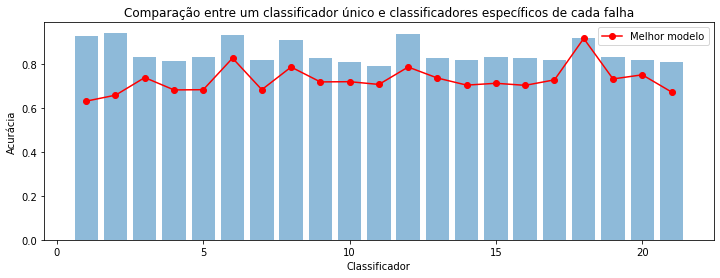

In [109]:
fig, ax = plt.subplots(figsize=(12,4))
ax.bar(range(1,22), accs_modelos, alpha=0.5)
ax.plot(range(1,22), accs_melhor_modelo, label='Melhor modelo', c='red', marker='o')
ax.set_xlabel("Classificador")
ax.set_ylabel("Acurácia")
ax.set_title("Comparação entre um classificador único e classificadores específicos de cada falha")
plt.legend();

# Classificador de falhas

In [16]:
from tensorflow.keras.callbacks import LearningRateScheduler

In [5]:
def unir_df_treino(cols):
    df = pd.DataFrame()
    for i in range(22):
        fnm = ''+str(i).zfill(2)
        dfalha_i = pd.read_csv('data/d{}.dat'.format(fnm), delim_whitespace=True, header=None)
        dfalha_i['falha'] = np.ones(len(dfalha_i), dtype='int')*i # 1
        df = pd.concat([df, dfalha_i])
    X = df[cols].values
    labels_treino = df['falha'].values
    X = normalize(X)
    X = X.reshape(len(X), 13, 2, 2)
    labels_treino = labels_treino.reshape(len(labels_treino), 1)
    return X, labels_treino

def get_df_teste(cols):
    df = pd.DataFrame()
    for i in range(22):
        fnm = ''+str(i).zfill(2)
        dfalha = pd.read_csv('data/d{}_te.dat'.format(fnm), delim_whitespace=True, header=None)
        dfalha['falha'] = np.ones(len(dfalha), dtype='int')*i
        # primeiros 160 são dados de normalidade
        dfalha.loc[np.arange(160), 'falha'] = 0
        df = pd.concat([df, dfalha])
    X = df[cols].values
    labels = df['falha'].values
    X = normalize(X)
    X = X.reshape(len(X), 13, 2, 2)
    labels = labels.reshape(len(labels), 1)
    return X, labels

In [6]:
colunas = np.arange(52)

In [12]:
X_treino, labels_treino = unir_df_treino(colunas)
X_teste, labels_teste = get_df_teste(colunas)

In [9]:
bs = 256
n_steps = X_treino.shape[0]//bs

In [ ]:
lista_drops = [
    [0, 0, 1], [0, 1, 1], [1, 1, 1], [1, 1, 0], [1, 0, 0], [1, 0, 1], [0, 1, 0]
]

In [ ]:
# lista de batch sizes
batch_sizes = [64, 128, 256]
# lista 
rs = [1, 2, 3]
treshold = 0.33
for b in batch_sizes:    
    for r in rs:
        for ld in lista_drops:
            loss_monitor = callbacks.EarlyStopping(monitor='val_accuracy', patience=10, mode='max')
            cnn_falhas = define_model(dropouts=[1,1,1], lnormalize=True, r=r, thirdl=1, nouts=22, n_steps=n_steps)
            hist = cnn_falhas.fit(X_treino, labels_treino, batch_size=b, verbose=0, epochs=500, callbacks=[loss_monitor], validation_data=(X_teste, labels_teste))
            title = "Falha {} bs:{} rs:{} dropouts:{} best:{:.3f}".format(falha, b, r, ld, loss_monitor.best)
            if loss_monitor.best>treshold:
                plot_acc_loss(title, hist)          

In [31]:
def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    
    return LearningRateScheduler(schedule)

lr_sched = step_decay_schedule(initial_lr=1e-4, decay_factor=0.75, step_size=n_steps)

In [33]:
es = callbacks.EarlyStopping(monitor='val_loss', patience=10)
hist = cnn_falhas.fit(X_treino, labels_treino, verbose=1, batch_size=bs, epochs=1000,
            validation_data=(X_teste, labels_teste), callbacks=[es, lr_sched])

Epoch 1/1000
42/42 [==============================] - 1s 19ms/step - loss: 4.3561 - accuracy: 0.0489 - val_loss: 4.2925 - val_accuracy: 0.1210 - lr: 1.0000e-04
Epoch 2/1000
42/42 [==============================] - 0s 11ms/step - loss: 4.2606 - accuracy: 0.0556 - val_loss: 4.1970 - val_accuracy: 0.0968 - lr: 1.0000e-04
Epoch 3/1000
42/42 [==============================] - 0s 11ms/step - loss: 4.1656 - accuracy: 0.0640 - val_loss: 4.1040 - val_accuracy: 0.1029 - lr: 1.0000e-04
Epoch 4/1000
42/42 [==============================] - 0s 12ms/step - loss: 4.0773 - accuracy: 0.0687 - val_loss: 4.0145 - val_accuracy: 0.1057 - lr: 1.0000e-04
Epoch 5/1000
42/42 [==============================] - 0s 11ms/step - loss: 3.9934 - accuracy: 0.0755 - val_loss: 3.9274 - val_accuracy: 0.1064 - lr: 1.0000e-04
Epoch 6/1000
42/42 [==============================] - 0s 11ms/step - loss: 3.9088 - accuracy: 0.0826 - val_loss: 3.8446 - val_accuracy: 0.1081 - lr: 1.0000e-04
Epoch 7/1000
42/42 [====================

In [27]:
# cnn_falhas.save("modelos/classificador_kaggle_78.h5")

In [51]:
cnn_pretreinado = tf.keras.models.load_model("modelos/classificador.h5")

In [71]:
falha_teste, labels_teste = get_df_teste(colunas)

In [56]:
labels_pred = cnn_pretreinado.predict(falha_1)
labels_pred = np.argmax(labels_pred, axis=1)
accuracy_score(labels_pred, labels_f1)

30/30 [==============================] - 0s 3ms/step


0.0010416666666666667

In [67]:
dffalha

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,falha
0,0.24889,3702.3,4502.7,9.4170,26.996,42.183,2705.2,75.173,120.40,0.33611,...,24.804,63.269,21.950,40.188,39.461,47.000,47.594,41.384,18.905,0
1,0.24904,3666.2,4526.0,9.2682,26.710,42.332,2705.5,74.411,120.41,0.33676,...,24.790,62.171,22.239,40.108,43.710,46.128,47.508,41.658,18.976,0
2,0.25034,3673.3,4501.3,9.4212,26.842,42.360,2705.3,75.125,120.41,0.33739,...,24.669,61.585,22.191,40.030,39.480,44.121,47.612,41.721,16.562,0
3,0.25109,3657.8,4497.8,9.3792,26.528,41.982,2707.3,73.992,120.38,0.33664,...,24.595,61.561,21.959,40.121,32.848,45.858,47.459,40.836,20.094,0
4,0.24563,3698.0,4537.4,9.3746,26.736,42.354,2705.3,75.283,120.42,0.32521,...,24.451,61.388,22.271,39.538,36.682,45.753,47.458,41.727,18.330,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,0.27523,3671.0,4466.0,9.3419,27.046,42.081,2667.9,70.154,120.40,0.34919,...,27.136,61.302,21.065,42.453,36.285,45.960,31.423,41.172,16.318,21
956,0.20483,3647.4,4490.1,9.3633,27.066,42.666,2668.4,69.698,120.41,0.32260,...,20.300,61.302,21.192,39.202,40.665,45.334,31.037,41.481,17.050,21
957,0.20527,3625.7,4474.0,9.3742,27.040,41.639,2668.5,69.244,120.39,0.32148,...,20.256,61.302,21.249,39.339,39.426,51.300,30.616,40.997,14.843,21
958,0.23677,3664.5,4526.8,9.3336,26.738,42.058,2669.7,69.251,120.41,0.32380,...,23.585,61.302,21.206,39.534,40.727,46.580,30.466,41.234,18.443,21


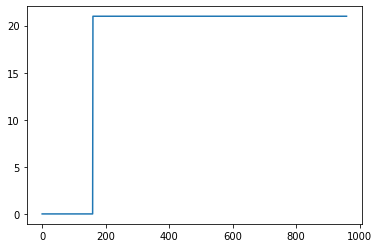

In [69]:
dffalha['falha'].value_counts()

0     4320
1      800
20     800
19     800
18     800
17     800
16     800
15     800
14     800
13     800
12     800
11     800
10     800
9      800
8      800
7      800
6      800
5      800
4      800
3      800
2      800
21     800
Name: falha, dtype: int64